In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'clenching',
    'away',
    'come'
]

data = np.concatenate([
    np.load('data/seq_clenching.npy'),
    np.load('data/seq_away.npy'),
    np.load('data/seq_come.npy'),
], axis=0)

data.shape

(632, 30, 100)

In [3]:
labelPath = 'data/labels.txt'
dataPath = 'data'

In [4]:
from service import train

with open(labelPath, 'r') as f:
    lines = f.readlines()
    data = np.concatenate([
        np.load(f'{dataPath}/seq_{line.strip().split()[0]}.npy') for line in lines
    ], axis=0)
    actions = [line.strip().split()[1] for line in lines]

data.shape, actions

((632, 30, 100), ['0', '1', '2'])

In [5]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

x_data.shape, labels.shape

((632, 30, 99), (632,))

In [6]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))

In [7]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2022)

print(x_train.shape, y_train.shape)

(568, 30, 99) (568, 3)


In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.regularizers import l2

model = Sequential([
    GRU(64, activation='tanh', input_shape=x_train.shape[1:3]),
    Dense(32, activation='tanh'),
    Dense(8, activation='tanh'),
    Dense(len(actions), activation='softmax')
])

# model = Sequential([
#     GRU(64, activation='tanh', input_shape=x_train.shape[1:3]),
#     Dense(32, activation='tanh'),
#     Dropout(0.3),
#     Dense(len(actions), activation='softmax')
# ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                31680     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define the callbacks
callbacks = [
    ModelCheckpoint('models/base_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=30, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_acc', patience=50, verbose=1, mode='auto')
]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/200
29/36 [=======================>......] - ETA: 0s - loss: 0.6423 - acc: 0.8254
Epoch 1: val_acc improved from -inf to 1.00000, saving model to models\base_model.h5
36/36 [==============================] - 2s 19ms/step - loss: 0.5797 - acc: 0.8574 - val_loss: 0.2559 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/200
30/36 [========================>.....] - ETA: 0s - loss: 0.2085 - acc: 1.0000
Epoch 2: val_acc did not improve from 1.00000
36/36 [==============================] - 0s 6ms/step - loss: 0.2011 - acc: 1.0000 - val_loss: 0.1516 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/200
30/36 [========================>.....] - ETA: 0s - loss: 0.1382 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
36/36 [==============================] - 0s 6ms/step - loss: 0.1347 - acc: 1.0000 - val_loss: 0.1124 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/200
30/36 [========================>.....] - ETA: 0s - loss: 0.1047 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
36/36 [=============

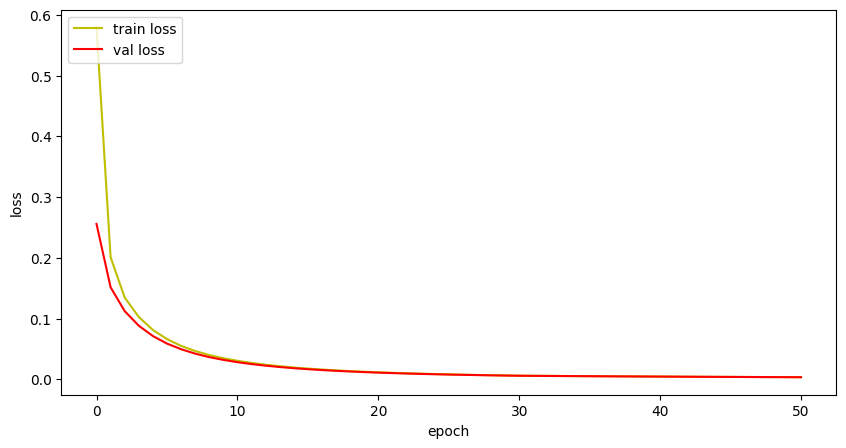

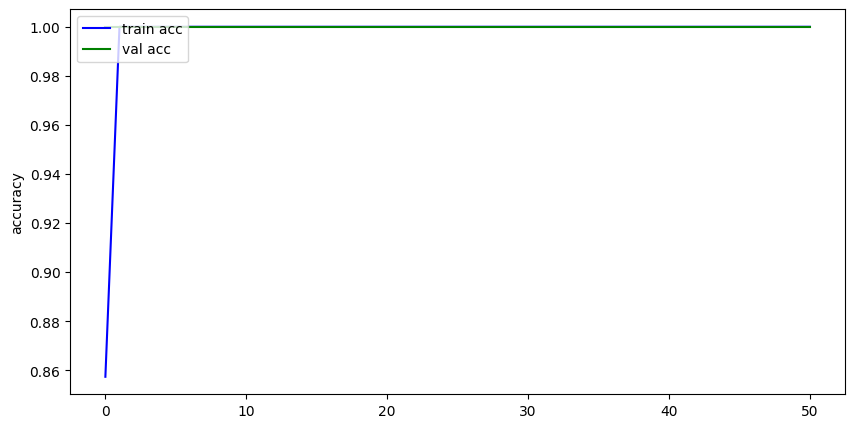

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10, 5))

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

fig, acc_ax = plt.subplots(figsize=(10, 5))
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()